In [51]:
import os
import pandas as pd
import datetime
import neurokit2 as nk
import nptdms
import numpy as np
import arrow


path = r"E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results\Patient5_1-corrected-rr.lvm"

path_patient = r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 5\recording 1\Patient 5_1.tdms"



In [2]:
# Load RR intervals from file (header lines 1-20, data starts at line 23)
# The file uses tabs as separators and comma as decimal separator (e.g. "0,000000\t0,244154")
skiprows = 22

# read with explicit tab separator and decimal comma; fallback to whitespace if needed
try:
    df_raw = pd.read_csv(path, skiprows=skiprows, sep='\t', header=0, engine='python', decimal=',')
except Exception:
    df_raw = pd.read_csv(path, skiprows=skiprows, header=0, delim_whitespace=True, engine='python', decimal=',')

# If no header row was present, ensure columns are strings and try again using first row as header
if df_raw.columns.to_series().astype(str).str.contains('[A-Za-z]').any() is False and df_raw.iloc[0].astype(str).str.contains('[A-Za-z]').any():
    df_raw = pd.read_csv(path, skiprows=skiprows, header=0, sep='\t', engine='python', decimal=',')

# Prefer numeric-typed columns; otherwise coerce columns to numeric (handling comma decimals)
num_cols = df_raw.select_dtypes(include=['number']).columns
if len(num_cols) > 0:
    rr = df_raw[num_cols[1]].dropna().reset_index(drop=True)
else:
    # coerce by replacing comma with dot then converting
    coerced = df_raw.apply(lambda col: pd.to_numeric(col.astype(str).str.replace(',', '.'), errors='coerce'))
    numeric_mask = coerced.notna().sum() > 0
    if numeric_mask.any():
        rr = coerced.loc[:, numeric_mask].iloc[:, 0].dropna().reset_index(drop=True)
    else:
        # fallback: first column
        rr = pd.to_numeric(df_raw.iloc[:, 0].astype(str).str.replace(',', '.'), errors='coerce').dropna().reset_index(drop=True)

rr.name = 'RR'
print(f"Loaded {len(rr)} RR intervals")
rr.head()

Loaded 186084 RR intervals


0    0.331858
1    0.382904
2    0.167871
3    0.204339
4    0.220332
Name: RR, dtype: float64

In [3]:
import re
from datetime import datetime

def read_header_datetime(path, default_date_fmt="%Y/%m/%d"):
    date_val = None
    time_val = None

    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            ls = line.strip()
            if ls.startswith("***End_of_Header***"):
                break

            low = ls.lower()
            # Fang 'Date\tYYYY/MM/DD'
            if low.startswith("date\t") and date_val is None:
                # tag højre side efter første tab
                date_val = ls.split("\t", 1)[1].strip()
            # Fang 'Time\tHH:MM:SS,ffffffffffff...' men ignorér Time_Pref
            elif "time" in low and "time_pref" not in low and low.startswith("time\t") and time_val is None:
                time_val = ls.split("\t", 1)[1].strip()

    if time_val is None:
        raise ValueError("Fandt ikke en 'Time' linje i headeren")
    # Eksempel: '13:06:19,1816539465369109152' eller '13:06:19.1816...'
    m = re.match(r"^(\d{2}:\d{2}:\d{2})[,.](\d+)$", time_val)
    if m:
        hhmmss, frac = m.group(1), m.group(2)
        # Trim/pad to 6 digits for microseconds and round based on the 7th digit
        if len(frac) > 6 and int(frac[6]) >= 5:
            frac6 = str(int(frac[:6]) + 1).zfill(6)
        else:
            frac6 = frac[:6].ljust(6, "0")
        # Construct the normalized time string with a period
        time_norm = f"{hhmmss}.{frac6}"
        time_dt = datetime.strptime(time_norm, "%H:%M:%S.%f")
    else:
        # fallback hvis ingen fraktion: 'HH:MM:SS'
        m2 = re.match(r"^\d{2}:\d{2}:\d{2}$", time_val)
        if not m2:
            raise ValueError(f"Kan ikke parse Time-strengen: {time_val!r}")
        time_dt = datetime.strptime(time_val, "%H:%M:%S")

    if date_val:
        # typisk '2016/10/12' — justér format hvis dine filer bruger andet
        try:
            date_dt = datetime.strptime(date_val, default_date_fmt).date()
            # Kombinér dato + klokkeslæt til én datetime
            combined = datetime.combine(date_dt, time_dt.time())
            return combined
        except ValueError:
            # Hvis datoformatet varierer, kan du prøve flere formater:
            for fmt in ("%Y-%m-%d", "%d/%m/%Y", "%d-%m-%Y"):
                try:
                    date_dt = datetime.strptime(date_val, fmt).date()
                    combined = datetime.combine(date_dt, time_dt.time())
                    return combined
                except ValueError:
                    pass
            # ellers bare returnér klokkeslættet alene
            return time_dt
    else:
        # ingen dato fundet – returnér kun klokkeslæt (dagsdato ukendt)
        return time_dt

# Brug:
ts = read_header_datetime(path)
print("Parsed header datetime:", ts)


Parsed header datetime: 2016-10-12 11:06:19.181654


In [ ]:
# Helper function to correct TDMS time values

def correctTime(time_val):
    """
    Normalize a TDMS header time value and return a tz-naive local datetime.

    Accepts numpy.datetime64, pandas.Timestamp, datetime, str or Arrow-like values.
    - Converts input to a pandas.Timestamp for robust parsing.
    - If a global HOURS_TO_ADD (int) is defined, that many hours will be added
      (useful for known manual offsets).
    - The caller code will convert the timestamp to an Arrow object, set UTC,
      convert to Europe/Copenhagen and return a tz-naive local datetime.
    """
    if time_val is None:
        raise ValueError("time_val must not be None")

    # Parse/normalize to pandas Timestamp for safe arithmetic
    try:
        t = pd.to_datetime(time_val)
    except Exception as e:
        raise ValueError(f"Unable to parse time_val: {e}")

    # Optionally apply a global hours offset if present
    add_hours = globals().get("HOURS_TO_ADD", 0)
    try:
        add_hours = int(add_hours)
    except Exception:
        add_hours = 0

    if add_hours != 0:
        t = t + pd.Timedelta(hours=add_hours)

    return t

In [48]:
# Read TDMS file
try:
    tdms = nptdms.TdmsFile.read(path_patient)
except Exception as e:
    raise RuntimeError(f"Failed to read TDMS file: {e}")

# List groups
groups = tdms.groups()
print("Groups found:", [g.name for g in groups])

# Collect channel data into a dict of pandas Series
channels = {}
tdms_time_printed = globals().get('tdms_time_printed', False)

for g in groups:
    for ch in g.channels():
        key = f"{g.name}.{ch.name}"
        try:
            arr = ch[:]  # numpy array of channel samples
        except Exception:
            arr = ch.data  # fallback
        channels[key] = pd.Series(arr, name=key)

        # Print "Time" from TDMS header/properties once
        # if not tdms_time_printed:
        time_val_tdms = None

        # file-level properties
        props = getattr(tdms, "properties", {}) or {}
        if isinstance(props, dict):
            for k, v in props.items():
                if "time" in str(k).lower():
                    time_val_tdms = v
                    break

        # fallback: file_info dict-like
        if time_val_tdms is None and hasattr(tdms, "file_info"):
            fi = getattr(tdms, "file_info") or {}
            if isinstance(fi, dict):
                for k, v in fi.items():
                    if "time" in str(k).lower():
                        time_val_tdms = v
                        break

        # channel-level properties
        if time_val_tdms is None and hasattr(ch, "properties"):
            ch_props = getattr(ch, "properties") or {}
            if isinstance(ch_props, dict):
                for k, v in ch_props.items():
                    if "time" in str(k).lower():
                        time_val_tdms = correctTime(v)
                        break

        if time_val_tdms is not None:
            print("Time from header:", time_val_tdms)
        else:
            print("No 'Time' property found in TDMS header/channel properties")

        globals()["tdms_time_printed"] = True
        tdms_time_printed = True

# Build DataFrame (will align by index; if lengths differ, shorter series get NaN)
df_tdms = pd.concat(channels, axis=1)

print(f"Loaded TDMS with shape: {df_tdms.shape}")
df_tdms.head()


Groups found: ['Untitled']
Time from header: 2016-10-12 11:05:02
Loaded TDMS with shape: (82460288, 1)


,Untitled.EKG
0,-70.270817
1,-1.377859
2,37.202197
3,-45.469352
4,-144.675212


In [47]:
# tid = correctTime(time_val_tdms)
# print("Corrected local time:", tid)

In [49]:
# import arrow
# import pandas as pd
# import numpy as np

# # Konverter til Arrow-objekt
# a = arrow.get(pd.to_datetime(time_val_tdms))

# # Antag at tidspunktet i TDMS-filen er i UTC (kan ændres hvis nødvendigt)
# a = a.replace(tzinfo="UTC")

# # Konverter til lokal tid — Arrow håndterer automatisk sommertid/vintertid
# a_local = a.to("Europe/Copenhagen")
# print(a.to("Europe/Copenhagen").naive)

# # Hvis du skal bruge en tz-aware datetime:
# corrected_dt_tzaware = a_local.datetime
# print(corrected_dt_tzaware)

# # Hvis du skal bruge en tz-naiv UTC datetime:
# corrected_dt_naive = a_local.to("UTC").naive

# # Eller evt. bevare lokal tid uden tzinfo:
# corrected_dt_local_naive = a_local.naive

# # Konverter til numpy.datetime64 hvis du vil:
# time_val_tdms = np.datetime64(corrected_dt_naive, "us")

# print("Original (UTC):", a)
# print("Lokal tid (med DST-håndtering):", a_local)
# print("Korrigeret (naiv UTC):", corrected_dt_naive)
# print("Korrigeret (lokal naive):", corrected_dt_local_naive)

# print("Final numpy.datetime64:", time_val_tdms)


In [50]:
import neurokit2 as nk

fs = 512

ecg_raw = df_tdms['Untitled.EKG']
ecg_cleaned = nk.ecg_clean(df_tdms['Untitled.EKG'], sampling_rate=fs)
ecg_peaks, info = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs)
binary_peaks_ecg = ecg_peaks['ECG_R_Peaks'].values

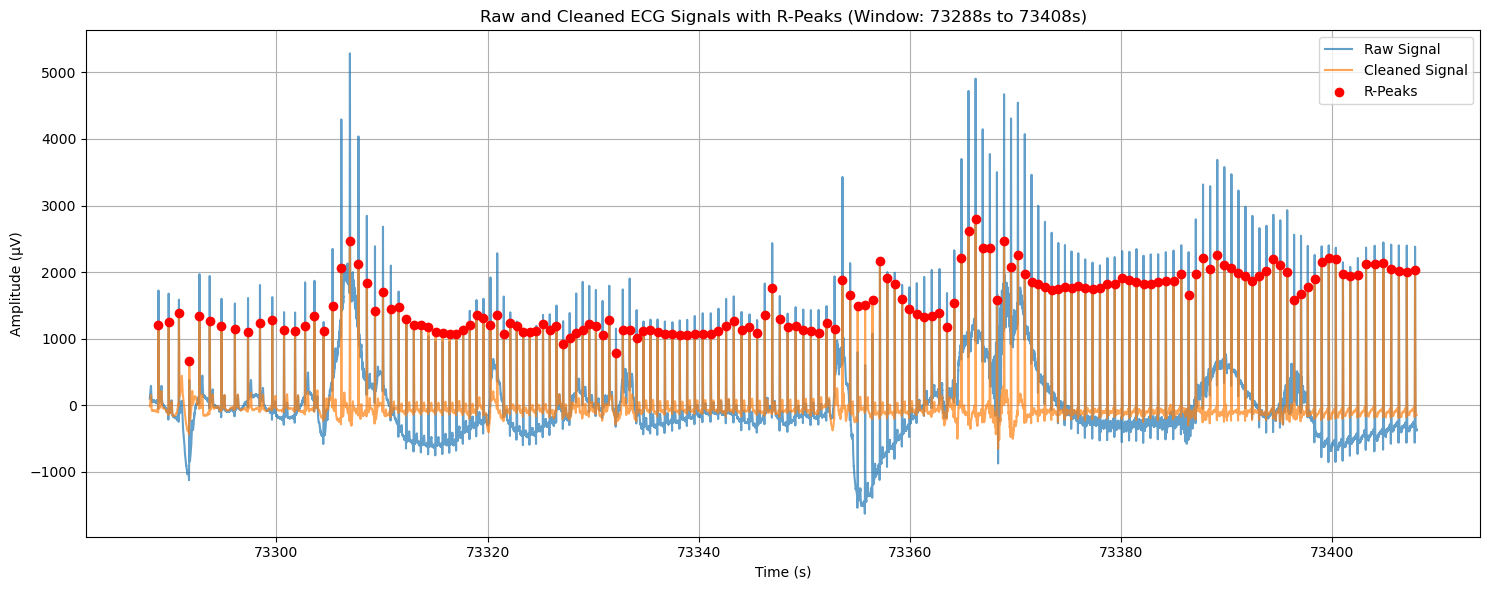

In [6]:
import numpy as np

import matplotlib.pyplot as plt

# Define parameters for the window
fs = 512  # Sampling rate
start_time = 73288  # Start time in seconds
# start_time = 272547
duration = 120  # Duration of the window in seconds

# Calculate start and end indices for the window
start_idx = int(start_time * fs)
end_idx = int((start_time + duration) * fs)

# Extract the raw and cleaned signal for the window
raw_window = arr[start_idx:end_idx]
cleaned_window = ecg_cleaned[start_idx:end_idx]

# Create a time axis for the window
time_axis = np.arange(start_idx, end_idx) / fs

# Extract R-peaks within the window
r_peak_indices = np.flatnonzero(binary_peaks_ecg[start_idx:end_idx]) + start_idx
r_peak_times = r_peak_indices / fs
r_peak_values = cleaned_window[r_peak_indices - start_idx]

# Plot the signals and R-peaks
plt.figure(figsize=(15, 6))
plt.plot(time_axis, raw_window, label="Raw Signal", alpha=0.7)
plt.plot(time_axis, cleaned_window, label="Cleaned Signal", alpha=0.7)
plt.scatter(r_peak_times, r_peak_values, color='red', label="R-Peaks", zorder=5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title(f"Raw and Cleaned ECG Signals with R-Peaks (Window: {start_time}s to {start_time + duration}s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
# Calculate time difference between starttime 10.10.16 11:05:02 and seizure time 13.10.16 14:47:29
# Note: the notebook already did "from datetime import datetime" earlier,
# so use datetime(...) (the class) rather than datetime.datetime(...)
starttime = datetime(2016, 10, 12, 11, 5, 2)
seizure_time = datetime(2016, 10, 13, 7, 26, 30)
time_difference = seizure_time - starttime
print("Time difference:", time_difference)

# To secounds
time_difference_seconds = time_difference.total_seconds()
print("Time difference in seconds:", time_difference_seconds)

time_difference_seconds*512

Time difference: 20:21:28
Time difference in seconds: 73288.0


37523456.0

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import correlate, convolve

fs = 512.0

# ---------- 1) Læs RR fra LabVIEW robust ----------
def read_labview_rr(path, skiprows=22):
    """Læs RR (sek) robust fra LabVIEW .lvm/.txt."""
    try:
        df = pd.read_csv(path, sep="\t", engine="python", skiprows=skiprows, header=0, decimal=",")
    except Exception:
        df = pd.read_csv(path, sep=None, engine="python", skiprows=skiprows, header=0)
        df = df.apply(lambda s: pd.to_numeric(s.astype(str).str.replace(",", "."), errors="coerce"))
    # vælg kolonne der ligner sekunder
    if "Untitled" in df.columns:
        rr = pd.to_numeric(df["Untitled"], errors="coerce").dropna().to_numpy(float)
    else:
        rr = None
        for c in df.columns:
            lc = str(c).lower()
            if lc in ("x_value","xvalue","comment"): 
                continue
            v = pd.to_numeric(df[c], errors="coerce").dropna().to_numpy(float)
            if v.size and 0.1 < np.nanmedian(v) < 5.0:
                rr = v; break
        if rr is None:
            rr = pd.to_numeric(df.iloc[:, 1 if df.shape[1]>1 else 0], errors="coerce").dropna().to_numpy(float)
    # enhedssikring
    med = np.nanmedian(rr)
    if med > 10000: rr = rr/1_000_000.0
    elif med > 5:   rr = rr/1_000.0
    return rr

# ---------- 2) Byg globale LabVIEW-peak samples fra RR + offset(seconds) ----------
def lab_rr_to_global_samples(rr_seconds, fs, offset_sec):
    """RR (sek) -> kumulativ tid -> samples + global offset (sek)."""
    t_rel = np.concatenate(([0.0], np.cumsum(rr_seconds)))
    s_rel = np.rint(t_rel * fs).astype(int)
    s_off = int(round(offset_sec * fs))
    return s_rel + s_off

# ---------- 3) Mål og kompensér filter-delay mellem rå og cleaned ----------
def align_cleaned_to_raw(ecg_raw, ecg_cleaned, fs, probe_start_s=10000, probe_len_s=10):
    """Mål lag mellem renset og rå; returnér alignede serier + lag (samples)."""
    x = np.asarray(ecg_raw, dtype=float)
    y = np.asarray(ecg_cleaned, dtype=float)
    i0 = int(probe_start_s*fs); n = int(probe_len_s*fs)
    xa = x[i0:i0+n] - x[i0:i0+n].mean()
    ya = y[i0:i0+n] - y[i0:i0+n].mean()
    c = correlate(ya, xa, mode="full")
    lags = np.arange(-len(xa)+1, len(xa))
    lag = int(lags[np.argmax(c)])  # >0: cleaned forsinket
    if lag > 0:
        y2 = y[lag:]; x2 = x[:len(y2)]
    elif lag < 0:
        x2 = x[-lag:]; y2 = y[:len(x2)]
    else:
        x2, y2 = x, y
    return x2, y2, lag

# ---------- 4) Index-baseret sammenligning (binære peak-trains) ----------
def event_metrics_from_indices(len_signal, gold_idx, test_idx, tol_samples):
    gold = np.zeros(len_signal, dtype=np.uint8); gold[np.asarray(gold_idx)] = 1
    test = np.zeros(len_signal, dtype=np.uint8); test[np.asarray(test_idx)] = 1
    # fuzzy overlap via 1D vindue
    win = np.ones(2*tol_samples+1, dtype=int)
    # convolve(gold, win) * test >0  => TP-mask for test
    tp_mask = (convolve(gold, win, mode='same') * test) > 0
    TP = int(tp_mask.sum())
    FP = int(test.sum() - TP)
    FN = int(gold.sum() - TP)
    sens = TP/(TP+FN) if TP+FN>0 else np.nan
    ppv  = TP/(TP+FP) if TP+FP>0 else np.nan
    f1   = 2*sens*ppv/(sens+ppv) if (sens>0 and ppv>0) else np.nan
    return {"TP":TP,"FP":FP,"FN":FN,"Sensitivity":sens,"PPV":ppv,"F1":f1}

def event_metrics_overlap_lag(gold_idx, test_idx, fs, tol_ms=40, max_lag_ms=150):
    """Klip til overlap, estimer lille lag, og beregn TP/FP/FN/Sens/PPV/F1."""
    gold_idx = np.asarray(gold_idx, dtype=int)
    test_idx = np.asarray(test_idx, dtype=int)
    lo = max(gold_idx.min(), test_idx.min())
    hi = min(gold_idx.max(), test_idx.max())
    if hi <= lo:
        raise ValueError("Ingen tidsligt overlap mellem peak-serierne.")
    # lokaliser til overlap
    g = gold_idx[(gold_idx>=lo)&(gold_idx<hi)] - lo
    t = test_idx[(test_idx>=lo)&(test_idx<hi)] - lo
    N = int(hi - lo)
    # lav binære tog
    a = np.zeros(N, dtype=np.uint8); a[g] = 1
    b = np.zeros(N, dtype=np.uint8); b[t] = 1
    # find bedste lille lag
    maxlag = int(round(max_lag_ms/1000*fs))
    bestlag = 0; best = -1
    for lag in range(-maxlag, maxlag+1):
        if lag<0: score = (a[:lag] & b[-lag:]).sum()
        elif lag>0: score = (a[lag:] & b[:-lag]).sum()
        else: score = (a & b).sum()
        if score > best: best, bestlag = score, lag
    # shift test/gold efter lag
    if bestlag > 0:
        t = t[bestlag:]; N2 = N - bestlag
        a2 = a[:N2]; b2 = b[bestlag:]
    elif bestlag < 0:
        g = g[-bestlag:]; N2 = N + bestlag
        a2 = a[-bestlag:]; b2 = b[:N2]
    else:
        a2, b2, N2 = a, b, N
    # fuzzy match med tolerance
    tol = int(round(tol_ms/1000*fs))
    win = np.ones(2*tol+1, dtype=int)
    TP = int((convolve(a2, win, mode='same') * b2 > 0).sum())
    FP = int(b2.sum() - TP)
    FN = int(a2.sum() - TP)
    sens = TP/(TP+FN) if (TP+FN)>0 else np.nan
    ppv  = TP/(TP+FP) if (TP+FP)>0 else np.nan
    f1   = 2*sens*ppv/(sens+ppv) if (sens>0 and ppv>0) else np.nan
    return {"TP":TP,"FP":FP,"FN":FN,"Sensitivity":sens,"PPV":ppv,"F1":f1,
            "lag_samples":bestlag,"tol_samples":tol,"N_overlap":N2,"lo":lo,"hi":lo+N2}


Lag(cleaned vs raw): 0 samples (0.000 s)
{'TP': 14730, 'FP': 152458, 'FN': 171355, 'Sensitivity': 0.07915737431818792, 'PPV': 0.08810440940737374, 'F1': 0.08339159799928102}


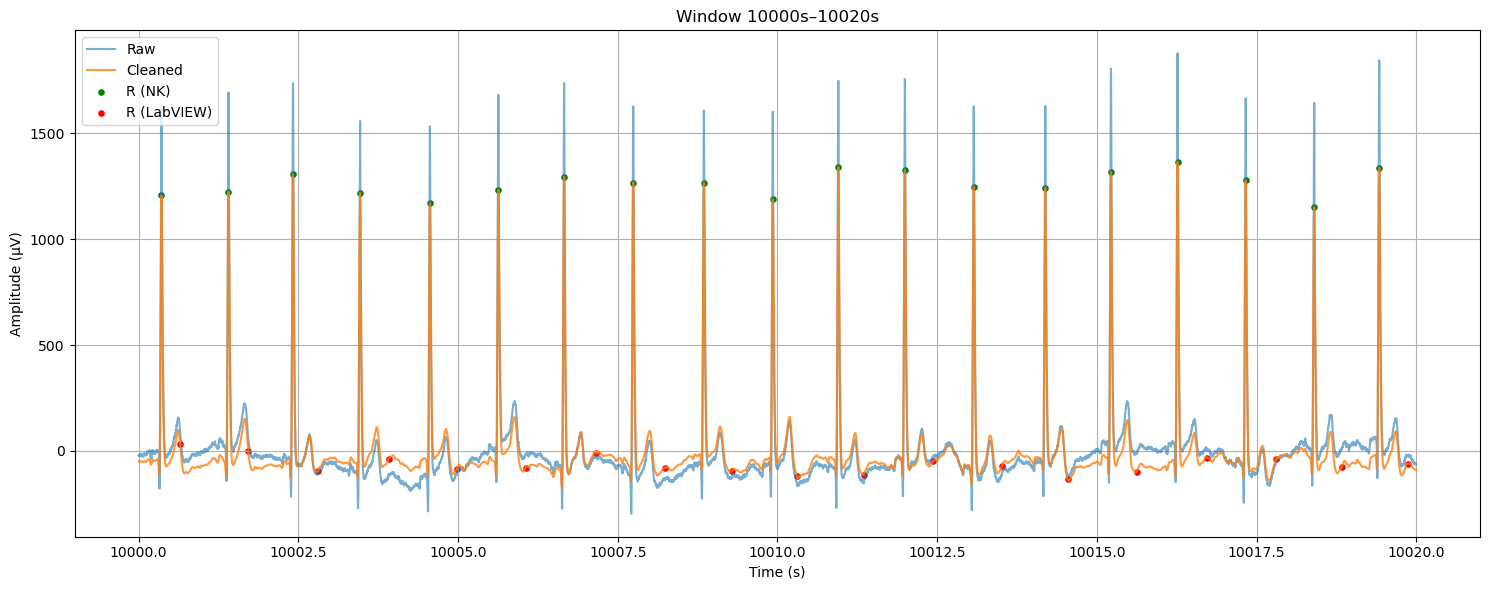

In [8]:
# 0) Inputs fra din eksisterende kode
ecg_raw_np = df_tdms['Untitled.EKG'].to_numpy()
ecg_clean_np = np.asarray(ecg_cleaned)  # fra nk.ecg_clean
nk_binary = ecg_peaks['ECG_R_Peaks'].to_numpy()  # samme længde som input
nk_idx = np.flatnonzero(nk_binary)

# 1) (valgfrit) align rå og cleaned (og shifte NK-peaks tilsvarende)
raw_al, clean_al, lag_rc = align_cleaned_to_raw(ecg_raw_np, ecg_clean_np, fs)
if lag_rc != 0:
    nk_idx = nk_idx - lag_rc
    nk_idx = nk_idx[nk_idx >= 0]
print(f"Lag(cleaned vs raw): {lag_rc} samples ({lag_rc/fs:.3f} s)")

# 2) LabVIEW ⇒ globale peaks
rr = read_labview_rr(path)             # din rr path
offset_sec = 77.0                      # brug Time-differencen fra LabVIEW header (s)
lab_idx = lab_rr_to_global_samples(rr, fs, offset_sec)

# 3) Index-baseret evaluering på hele signalet
N = len(raw_al)
TOL = int(round(0.04*fs))              # 40 ms
metrics = event_metrics_from_indices(N, lab_idx, nk_idx, TOL)
print(metrics)

# 4) Plot et vindue (global akse)
start_s, dur_s = 10000, 20
s = int(start_s*fs); e = int((start_s+dur_s)*fs)
t = np.arange(s,e)/fs
raw_win   = raw_al[s:e]
clean_win = clean_al[s:e]
lab_loc = lab_idx[(lab_idx>=s)&(lab_idx<e)] - s
nk_loc  = nk_idx [(nk_idx >=s)&(nk_idx <e)] - s

import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(t, raw_win,   label='Raw', alpha=0.6)
plt.plot(t, clean_win, label='Cleaned', alpha=0.8)
plt.scatter(t[nk_loc],  clean_win[nk_loc],  s=14, c='green', label='R (NK)')
plt.scatter(t[lab_loc], clean_win[lab_loc], s=14, c='red',   label='R (LabVIEW)')
plt.xlabel("Time (s)"); plt.ylabel("Amplitude (µV)")
plt.title(f"Window {start_s}s–{start_s+dur_s}s")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


Lag(cleaned vs raw): 0 samples (0.000s)
{'TP': 14987, 'FP': 152085, 'FN': 171097, 'Sensitivity': 0.08053889641237291, 'PPV': 0.0897038402604865, 'F1': 0.084874672949065, 'lag_samples': 69, 'tol_samples': 20, 'N_overlap': 82270665, 'lo': 39424, 'hi': 82310089}


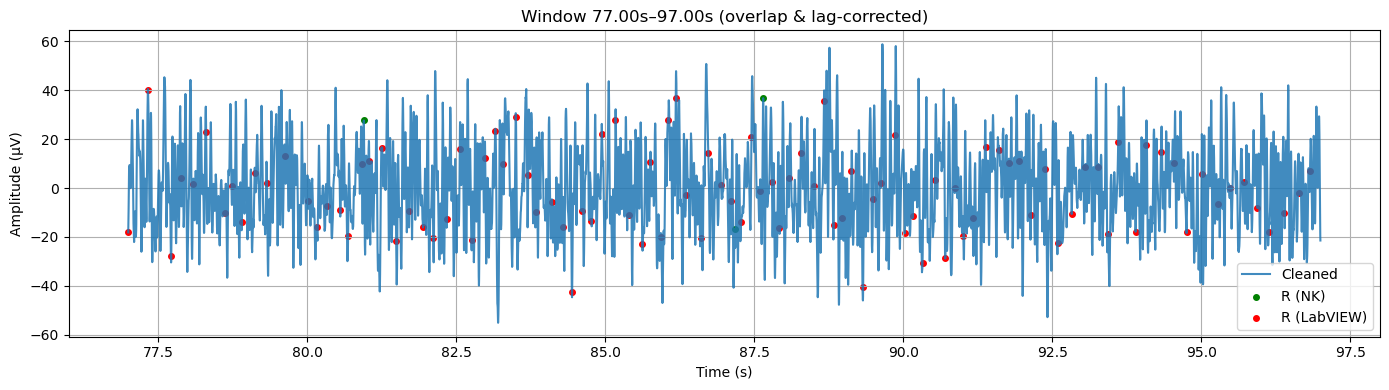

In [40]:
# Forudsætninger fra din notebook:
# fs = 512
# df_tdms['Untitled.EKG']  -> rå signal
# ecg_cleaned               -> renset signal (samme fs, samme længde som rå)
# ecg_peaks['ECG_R_Peaks']  -> binær serie
# path                      -> LabVIEW RR-fil (.lvm)
# LAB_TIME_OFFSET_SEC       -> forskel mellem TDMS start og LabVIEW "Time:" (fx 77.0)

LAB_TIME_OFFSET_SEC = 77.0  # justér denne værdi efter behov

raw = df_tdms['Untitled.EKG'].to_numpy()
clean = np.asarray(ecg_cleaned)
nk_binary = ecg_peaks['ECG_R_Peaks'].to_numpy()
nk_idx = np.flatnonzero(nk_binary)

# 1) Align raw/cleaned og shif t NK-peakindeks tilsvarende
raw_al, clean_al, lag_rc = align_cleaned_to_raw(raw, clean, fs)
if lag_rc != 0:
    nk_idx = nk_idx - lag_rc
    nk_idx = nk_idx[nk_idx >= 0]
print(f"Lag(cleaned vs raw): {lag_rc} samples ({lag_rc/fs:.3f}s)")

# 2) LabVIEW RR -> globale samples via header-offset
rr = read_labview_rr(path)
lab_idx = lab_rr_to_global_samples(rr, fs, offset_sec=LAB_TIME_OFFSET_SEC)

# 3) Index-baseret evaluering med overlap + lag + tolerance
metrics = event_metrics_overlap_lag(lab_idx, nk_idx, fs, tol_ms=40, max_lag_ms=150)
print(metrics)

# 4) Hurtigt plot i overlap
lo, hi = metrics["lo"], metrics["hi"]
start_s = lo/fs; dur_s = min(20.0, (hi-lo)/fs)
s = int(lo); e = int(lo + dur_s*fs)
t = np.arange(s,e)/fs
lab_loc = lab_idx[(lab_idx>=s)&(lab_idx<e)] - s
nk_loc  = nk_idx [(nk_idx >=s)&(nk_idx <e)] - s

import matplotlib.pyplot as plt
plt.figure(figsize=(14,4))
plt.plot(t, clean_al[s:e], label="Cleaned", alpha=0.85)
plt.scatter(t[nk_loc],  clean_al[s:e][nk_loc],  s=16, c='green', label='R (NK)')
plt.scatter(t[lab_loc], clean_al[s:e][lab_loc], s=16, c='red',   label='R (LabVIEW)')
plt.xlabel("Time (s)"); plt.ylabel("Amplitude (µV)")
plt.title(f"Window {start_s:.2f}s–{start_s+dur_s:.2f}s (overlap & lag-corrected)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


In [11]:
import numpy as np
import matplotlib.pyplot as plt

fs = 512

# ---- 1) Vindue i GLOBAL tid ----
start_time = 100000.0
duration   = 5.0
start_idx_global = int(start_time * fs)
end_idx_global   = int((start_time + duration) * fs)

raw_win   = np.asarray(ecg_raw[start_idx_global:end_idx_global])     # globalt udsnit
clean_win = np.asarray(ecg_cleaned[start_idx_global:end_idx_global]) # globalt udsnit
t = np.arange(start_idx_global, end_idx_global) / fs                 # global tid i sek.

# ---- 2) LabVIEW: RR -> relative peaks ----
lab_rr_s = df_lab["rr_s"].dropna().to_numpy()        # RR (sek)
t_lab_rel = np.concatenate(([0.0], np.cumsum(lab_rr_s)))    # tid siden 1. LAB-peak (sek)
lab_rel_samples = np.rint(t_lab_rel * fs).astype(int)       # relative samples

# >>> VIGTIGT: offset mellem råsignal-start og LabVIEW-start <<<
offset_sec = 77.181654  # fx 1 min 17 s — erstat med din faktiske forskel
lab_offset_samples = int(round(offset_sec * fs))

# LabVIEW-peaks i GLOBAL samples
lab_peaks_global = lab_rel_samples + lab_offset_samples

# ---- 3) NeuroKit-peaks i GLOBAL samples ----
nk_peaks_global = np.asarray(rpeak_indices, dtype=int)

# ---- 4) (Valgfrit) finjustér offset med ±0.5 s lag-søgning ----
# Brug en kort lokal sekvens for robusthed (fx det aktuelle vindue)
def refine_lag(peaks_a, peaks_b, fs, search_sec=0.5):
    # binære peak-trains i vinduet med den grove offset
    lo, hi = start_idx_global, end_idx_global
    n = hi - lo
    a = np.zeros(n, dtype=np.uint8)
    b = np.zeros(n, dtype=np.uint8)
    a_idx = peaks_a[(peaks_a>=lo)&(peaks_a<hi)] - lo
    b_idx = peaks_b[(peaks_b>=lo)&(peaks_b<hi)] - lo
    a[a_idx] = 1; b[b_idx] = 1
    if a.sum()==0 or b.sum()==0:
        return 0  # intet at matche lige her
    maxlag = int(search_sec*fs)
    # krydskorrelation via convolution
    bestlag = 0; bestscore = -1
    for lag in range(-maxlag, maxlag+1):
        if lag < 0:
            score = (a[:lag] & b[-lag:]).sum()
        elif lag > 0:
            score = (a[lag:] & b[:-lag]).sum()
        else:
            score = (a & b).sum()
        if score > bestscore:
            bestscore, bestlag = score, lag
    return bestlag

lag = refine_lag(lab_peaks_global, nk_peaks_global, fs, search_sec=0.5)
if lag != 0:
    lab_peaks_global = lab_peaks_global + lag

# ---- 5) Maskér peaks ind i vinduet (GLOBAL -> lokale indeks til y) ----
mask_lab = (lab_peaks_global >= start_idx_global) & (lab_peaks_global < end_idx_global)
mask_nk  = (nk_peaks_global  >= start_idx_global) & (nk_peaks_global  < end_idx_global)
lab_local = lab_peaks_global[mask_lab] - start_idx_global
nk_local  = nk_peaks_global[mask_nk]   - start_idx_global

# ---- 6) Plot (global tid) ----
plt.figure(figsize=(15,6))
plt.plot(t, raw_win,   label='Raw Signal',    alpha=0.7)
plt.plot(t, clean_win, label='Cleaned Signal',alpha=0.7)
plt.scatter(t[lab_local], clean_win[lab_local], s=12, c='red',   label='R-Peaks (LabVIEW)')
plt.scatter(t[nk_local],  clean_win[nk_local],  s=12, c='green', label='R-Peaks (ECG Analysis)')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude (µV)')
plt.title(f'Raw and Cleaned ECG Signals with R-Peaks (Window: {start_time}s to {start_time+duration}s)')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


NameError: name 'df_lab' is not defined

In [41]:
import numpy as np
from scipy.signal import correlate

fs = 512

x = np.asarray(ecg_raw,    dtype=float)
y = np.asarray(ecg_cleaned,dtype=float)

# Brug et kort udsnit hvor der er tydelige R-takker
i0 = 100000*fs
win = 10*fs
xa = x[i0:i0+win] - np.mean(x[i0:i0+win])
ya = y[i0:i0+win] - np.mean(y[i0:i0+win])

c = correlate(ya, xa, mode="full")              # y relativt til x
lags = np.arange(-len(xa)+1, len(xa))
lag_clean_vs_raw = lags[np.argmax(c)]           # >0 betyder: y er forsinket m. 'lag' samples

print("Lag(cleaned vs raw) [samples]:", lag_clean_vs_raw, " -> sek:", lag_clean_vs_raw/fs)

# Ret tidsaksen/serien konsekvent:
if lag_clean_vs_raw > 0:
    # flyt cleaned "tilbage" i tid
    ecg_cleaned_aligned = y[lag_clean_vs_raw:]
    ecg_raw_aligned     = x[:len(ecg_cleaned_aligned)]
elif lag_clean_vs_raw < 0:
    ecg_raw_aligned     = x[-lag_clean_vs_raw:]
    ecg_cleaned_aligned = y[:len(ecg_raw_aligned)]
else:
    ecg_raw_aligned, ecg_cleaned_aligned = x, y


Lag(cleaned vs raw) [samples]: 685  -> sek: 1.337890625


In [42]:
# NK peaks i GLOBAL samples (justér hvis de er relative):
nk_peaks_global = np.asarray(rpeak_indices, dtype=int)

# LabVIEW RR -> peaks (sek) -> samples
lab_rr_s = df_lab["rr_s"].dropna().to_numpy()
t_lab_rel = np.concatenate(([0.0], np.cumsum(lab_rr_s)))
lab_rel_samples = np.rint(t_lab_rel * fs).astype(int)

offset_sec = 77.0
lab_offset_samples = int(round(offset_sec * fs))
lab_peaks_global = lab_rel_samples + lab_offset_samples

# Finjustér LAB mod NK i et kort vindue (±0.5 s)
from scipy.signal import convolve

def refine_lag_in_window(peaks_a, peaks_b, lo, hi, fs, search_sec=0.5):
    n = hi - lo
    a = np.zeros(n, dtype=np.uint8)
    b = np.zeros(n, dtype=np.uint8)
    ai = peaks_a[(peaks_a>=lo)&(peaks_a<hi)] - lo
    bi = peaks_b[(peaks_b>=lo)&(peaks_b<hi)] - lo
    if ai.size==0 or bi.size==0: return 0
    a[ai]=1; b[bi]=1
    maxlag = int(search_sec*fs)
    bestlag = 0; bestscore = -1
    for lag in range(-maxlag, maxlag+1):
        if lag<0: score = (a[:lag] & b[-lag:]).sum()
        elif lag>0: score = (a[lag:] & b[:-lag]).sum()
        else: score = (a & b).sum()
        if score>bestscore: bestscore, bestlag = score, lag
    return bestlag

lo = 100000*fs; hi = lo + 5*fs
lag_lab_vs_nk = refine_lag_in_window(lab_peaks_global, nk_peaks_global, lo, hi, fs, search_sec=0.5)
lab_peaks_global = lab_peaks_global + lag_lab_vs_nk
print("Lag(LAB vs NK) [samples]:", lag_lab_vs_nk, " -> sek:", lag_lab_vs_nk/fs)


Lag(LAB vs NK) [samples]: -2  -> sek: -0.00390625


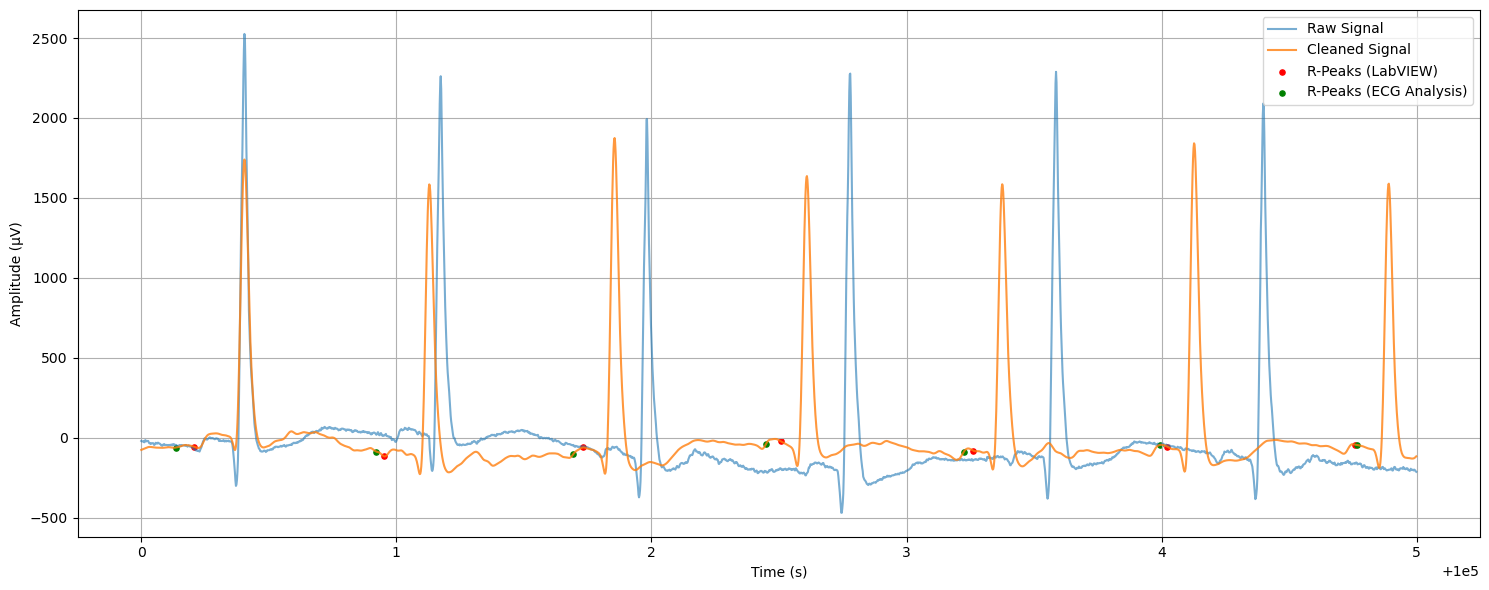

In [43]:
# Vælg et globalt vindue
start_time = 100000.0; duration = 5.0
start_idx = int(start_time*fs); end_idx = int((start_time+duration)*fs)

raw_win   = ecg_raw_aligned[start_idx:end_idx]
clean_win = ecg_cleaned_aligned[start_idx:end_idx]
t = np.arange(start_idx, end_idx)/fs

# Peaks ind i vinduet
lab_local = lab_peaks_global[(lab_peaks_global>=start_idx)&(lab_peaks_global<end_idx)] - start_idx
nk_local  = nk_peaks_global[(nk_peaks_global >=start_idx)&(nk_peaks_global <end_idx)] - start_idx

import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(t, raw_win,   label='Raw Signal',    alpha=0.6)
plt.plot(t, clean_win, label='Cleaned Signal',alpha=0.8)
plt.scatter(t[lab_local], clean_win[lab_local], s=14, c='red',   label='R-Peaks (LabVIEW)')
plt.scatter(t[nk_local],  clean_win[nk_local],  s=14, c='green', label='R-Peaks (ECG Analysis)')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude (µV)'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


In [ ]:
delay = 685  # fra din måling
if delay > 0:
    ecg_cleaned_aligned = ecg_cleaned[delay:]
    ecg_raw_aligned     = ecg_raw[:len(ecg_cleaned_aligned)]
else:
    ecg_raw_aligned     = ecg_raw[-delay:]
    ecg_cleaned_aligned = ecg_cleaned[:len(ecg_raw_aligned)]


In [ ]:
rpeak_indices_aligned = rpeak_indices - delay
rpeak_indices_aligned = rpeak_indices_aligned[rpeak_indices_aligned >= 0]


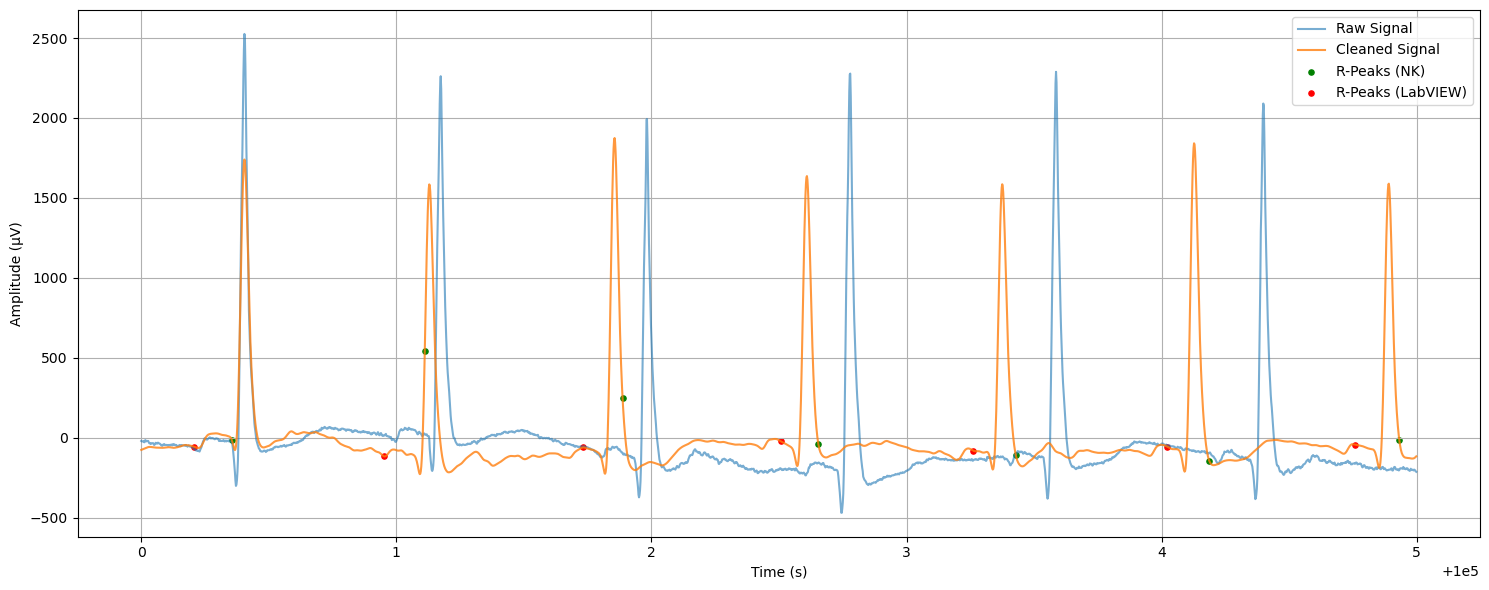

In [46]:
fs = 512
start_time = 100000.0
dur = 5.0
s = int(start_time*fs); e = int((start_time+dur)*fs)
t = np.arange(s, e)/fs

raw_win   = ecg_raw_aligned[s:e]
clean_win = ecg_cleaned_aligned[s:e]

# Peaks
nk = rpeak_indices_aligned
lab = lab_peaks_global  # fra før (inkl. dit LAB-offset og evt. ±2 samp fintuning)

nk_loc  = nk[(nk>=s)&(nk<e)] - s
lab_loc = lab[(lab>=s)&(lab<e)] - s

import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(t, raw_win,   label='Raw Signal', alpha=0.6)
plt.plot(t, clean_win, label='Cleaned Signal', alpha=0.8)
plt.scatter(t[nk_loc],  clean_win[nk_loc],  s=14, c='green', label='R-Peaks (NK)')
plt.scatter(t[lab_loc], clean_win[lab_loc], s=14, c='red',   label='R-Peaks (LabVIEW)')
plt.legend(); plt.grid(True); plt.xlabel("Time (s)"); plt.ylabel("Amplitude (µV)")
plt.tight_layout(); plt.show()


In [19]:
print("Binær peak-serie længde:", len(binary_peaks_ecg))
diff = len(binary_peaks_ecg) - len(binary_peaks)
print("Test - Difference between RR peaks and ECG peaks:", diff)

diff/512

Binær peak-serie længde: 82460288
Test - Difference between RR peaks and ECG peaks: 189298


369.72265625

In [20]:
# Calculate difference in start from ECG signal and LabView RR intervals, due to 60 secounds skip in LabView and settling time for calculations.
time_val_tdms = time_val_tdms + np.timedelta64(2, 'h')
time_difference = ts - time_val_tdms
print(f"Difference in start time: {time_difference}")

Difference in start time: 0:01:17.181654


In [21]:
sample_difference = time_difference.total_seconds() / 0.001953125
print(f"Difference in samples: {sample_difference}")

# Try removing this found difference from the ecg peaks to align with RR intervals
binary_peaks_ecg_aligned = binary_peaks_ecg[int(sample_difference):]
print("Aligned ECG peaks length:", len(binary_peaks_ecg_aligned))
# Compare with rr intervals length
print("Diff with RR intervals in s:", (len(binary_peaks_ecg_aligned) - len(binary_peaks))/512)

Difference in samples: 39517.006848
Aligned ECG peaks length: 82420771
Diff with RR intervals in s: 292.541015625


In [22]:
# Compare with detected R-peak indices from ECG analysis

# Print 1-10 idxices with 1's in binary_peaks_ecg_aligned and binary_peaks
indices_with_ones_ecg = np.flatnonzero(binary_peaks_ecg_aligned)[:10]
print(f"First 10 indices with 1's in binary_peaks_ecg_aligned: {indices_with_ones_ecg}")
# Calculate cumulative sum of binary_peaks_ecg_aligned and binary_peaks
# Count the number of 1's in both binary_peaks_ecg_aligned and binary_peaks
count_ones_ecg_aligned = np.sum(binary_peaks_ecg_aligned)
count_ones_rr = np.sum(binary_peaks)

print(f"Number of 1's in binary_peaks_ecg_aligned: {count_ones_ecg_aligned}")
print(f"Number of 1's in binary_peaks: {count_ones_rr}")

indices_with_ones_rr = np.flatnonzero(binary_peaks)[:20]
print(f"First 10 indices with 1's in binary_peaks: {indices_with_ones_rr}")

First 10 indices with 1's in binary_peaks_ecg_aligned: [ 1930  5115  5360 25853 28526 30601 35134 35781 36296 37649]
Number of 1's in binary_peaks_ecg_aligned: 167139
Number of 1's in binary_peaks: 186085
First 10 indices with 1's in binary_peaks: [   0  170  366  452  557  669  828  894  976 1085 1192 1345 1545 1618
 1707 1819 1888 2006 2070 2180]


In [23]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Ensure the arrays are of the same length for comparison
min_length = min(len(binary_peaks_ecg_aligned), len(binary_peaks))
predictions = binary_peaks_ecg_aligned[:min_length]
labels = binary_peaks[:min_length]

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()

# Print metrics
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Compute additional metrics
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
accuracy = accuracy_score(labels, predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Optionally, print a detailed classification report
print("\nClassification Report:")
print(classification_report(labels, predictions, target_names=["No Peak", "Peak"]))

True Positives (TP): 387
False Positives (FP): 166685
True Negatives (TN): 81918220
False Negatives (FN): 185698
Precision: 0.0023
Recall: 0.0021
F1-Score: 0.0022
Accuracy: 0.9957

Classification Report:
              precision    recall  f1-score   support

     No Peak       1.00      1.00      1.00  82084905
        Peak       0.00      0.00      0.00    186085

    accuracy                           1.00  82270990
   macro avg       0.50      0.50      0.50  82270990
weighted avg       1.00      1.00      1.00  82270990



In [24]:
ecg_cleaned = ecg_cleaned[int(sample_difference):]
ecg_raw = df_tdms['Untitled.EKG'][int(sample_difference):]

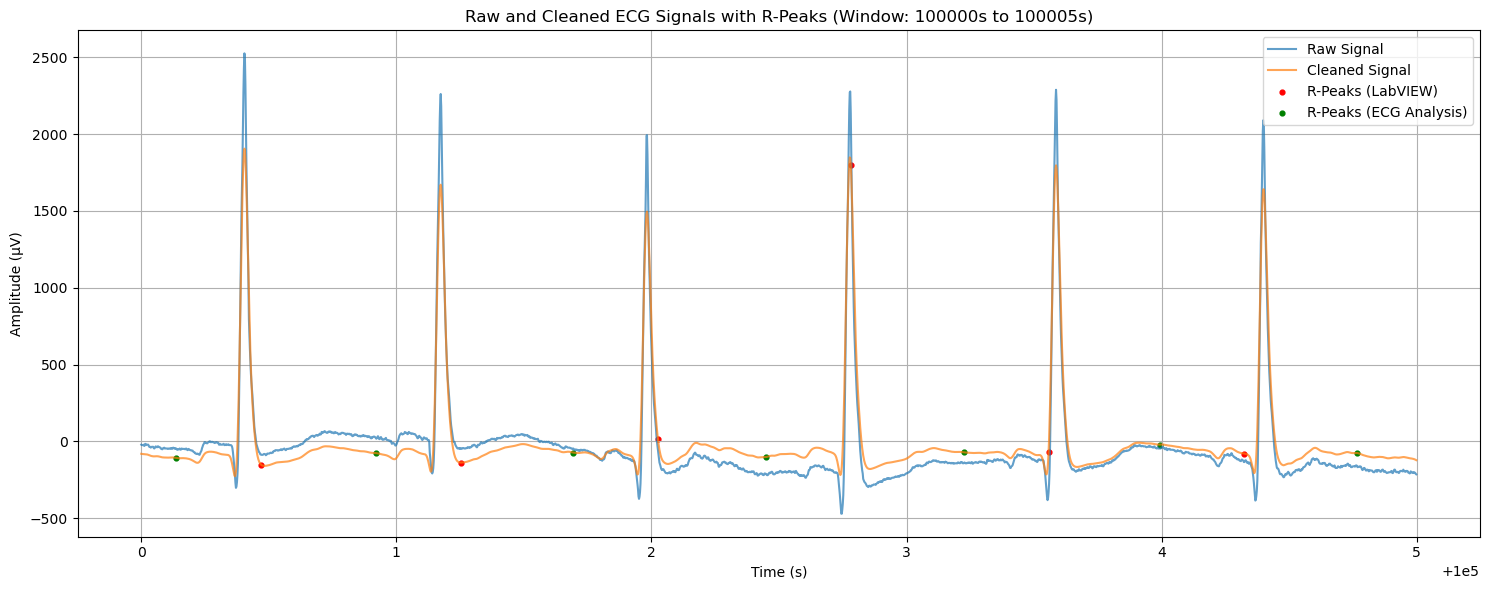

In [32]:
import numpy as np
import matplotlib.pyplot as plt

fs = 512
start_time = 100000
duration   = 5
start_idx  = int(start_time * fs)
end_idx    = int((start_time + duration) * fs)

# --- vindue + tidsakse ---
raw_win   = ecg_raw.iloc[start_idx:end_idx].reset_index(drop=True)
clean_win = ecg_cleaned.iloc[start_idx:end_idx].reset_index(drop=True) if hasattr(ecg_cleaned,'iloc') else ecg_cleaned[start_idx:end_idx]
t = np.arange(len(raw_win)) / fs + start_time

# --- NeuroKit peaks (globale i samples) ---
nk_peaks_global = np.asarray(rpeak_indices, dtype=int)

# --- LabVIEW peaks: RR -> relative peak-tider/-samples ---
lab_rr_s = df_lab["rr_s"].dropna().to_numpy()  # <- kolonnen hedder rr_s
t_lab_rel = np.concatenate(([0.0], np.cumsum(lab_rr_s)))        # sek siden 1. LabVIEW-peak
lab_rel_samples = np.rint(t_lab_rel * fs).astype(int)           # relative samples (0, …)

# --- Find globalt offset for LabVIEW-aksen (forankr første LabVIEW-peak til nærmeste NK-peak) ---
# hvis din df_lab i forvejen har globale samples, spring dette over og brug dem direkte
first_lab_rel = lab_rel_samples[0]  # typisk 0
k = np.argmin(np.abs(nk_peaks_global - first_lab_rel))
lab_offset_samples = nk_peaks_global[k] - first_lab_rel

lab_peaks_global = lab_rel_samples + lab_offset_samples  # nu i samme globale sample-akse som signalet

# --- maskér peaks ind i vinduet ---
mask_lab = (lab_peaks_global >= start_idx) & (lab_peaks_global < end_idx)
mask_nk  = (nk_peaks_global  >= start_idx) & (nk_peaks_global  < end_idx)

lab_local = lab_peaks_global[mask_lab] - start_idx
nk_local  = nk_peaks_global[mask_nk]   - start_idx

# Sørg for at konvertere til NumPy, så det altid virker
clean_arr = np.asarray(clean_win)

plt.figure(figsize=(15,6))
plt.plot(t, np.asarray(raw_win), label='Raw Signal', alpha=0.7)
plt.plot(t, clean_arr, label='Cleaned Signal', alpha=0.7)
plt.scatter(t[lab_local], clean_arr[lab_local], s=12, c='red',   label='R-Peaks (LabVIEW)')
plt.scatter(t[nk_local],  clean_arr[nk_local],  s=12, c='green', label='R-Peaks (ECG Analysis)')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude (µV)')
plt.title(f'Raw and Cleaned ECG Signals with R-Peaks (Window: {start_time}s to {start_time+duration}s)')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


In [9]:
wf_increase = 1/512

In [29]:
total_time = rr.sum()
print(f"Total time in rr: {total_time} seconds")

fs = 512

Total time in rr: 160685.028189 seconds


In [31]:
# Calculate cumulative sum of RR intervals to get R-peak times in seconds
rpeak_times = rr.cumsum()

# Convert R-peak times to sample indices
rpeak_indices = (rpeak_times / wf_increase).round().astype(int)

# Create an array with 1's at R-peak indices
wf_increase_array = np.zeros(int(rpeak_times.iloc[-1] / wf_increase) + 1)  # Total samples based on last R-peak time
wf_increase_array[rpeak_indices] = 1  # Set 1's at R-peak indices

# Convert to DataFrame
df_rpeaks = pd.DataFrame({'R_Peak': wf_increase_array})
print(f"Created DataFrame with shape: {df_rpeaks.shape}")
df_rpeaks.head()

NameError: name 'wf_increase' is not defined

In [28]:
import numpy as np
import pandas as pd

# Create a DataFrame with 1's at R-peak indices

# Calculate cumulative sum of RR intervals to get R-peak times in seconds
rpeak_times = rr.cumsum()

# Convert R-peak times to sample indices
rpeak_indices = (rpeak_times * fs).round().astype(int)

# Create a DataFrame with 1's at R-peak indices
wf_increase = np.zeros(int(total_time * fs))  # Total samples based on total_time and fs
wf_increase[rpeak_indices-1] = 1  # Set 1's at R-peak indices

# Convert to DataFrame
df_rpeaks = pd.DataFrame({'R_Peak': wf_increase})
print(f"Created DataFrame with shape: {df_rpeaks.shape}")
df_rpeaks.head()

NameError: name 'total_time' is not defined

In [11]:
print(f"R-peak indices (first 10): {rpeak_indices[:10].values}")

R-peak indices (first 10): [ 170  366  452  557  669  828  894  976 1085 1192]


In [19]:
# Merge RR intervals shorter than 0.27 s into the smaller adjacent interval.
# Uses existing `rr` Series from the notebook.
threshold = 60/220

vals = rr.tolist()
removed = 0

while True:
    # find first short interval
    short_idx = next((i for i, v in enumerate(vals) if v < threshold), None)
    if short_idx is None:
        break

    v = vals[short_idx]
    # choose neighbor (previous or next) with the smaller value (handle edges)
    if short_idx == 0:
        neighbor = 1
    elif short_idx == len(vals) - 1:
        neighbor = short_idx - 1
    else:
        neighbor = short_idx - 1 if vals[short_idx - 1] <= vals[short_idx + 1] else short_idx + 1

    # add short interval to chosen neighbor and remove it
    vals[neighbor] += v
    vals.pop(short_idx)
    removed += 1

rr_clean = pd.Series(vals, name='RR')
print(f"Removed {removed} short intervals. Before: {len(rr)}, After: {len(rr_clean)}")

Removed 13435 short intervals. Before: 186084, After: 172649


In [20]:
print(len(rr_clean))

172649


In [31]:
rr_clean_total = 0

for i in rr_clean:
    rr_clean_total += i

print(f"Total duration of cleaned RR intervals: {rr_clean_total} seconds")

Total duration of cleaned RR intervals: 160685.02818899963 seconds


In [12]:
fs = 512
s_total = 82460288/fs
print(f"Total duration based on original signal sampling rate: {s_total} seconds")

remaining_time = s_total - total_time
print(f"Remaining time after subtracting total_time from s_total: {remaining_time} seconds")

remove_start = 60
print(f"Samples to remove at start: {remove_start}")
remove_end = 300
print(f"Samples to remove at end: {remove_end}")

s_missing = s_total - (total_time + (remove_start + remove_end))
print(f"Missing time after removing start/end: {s_missing} seconds")

# From timestamp in rr-result file is shown a start time of 11:06:19,181654
# From the ECG file there is a offset of 17 seconds

Total duration based on original signal sampling rate: 161055.25 seconds
Remaining time after subtracting total_time from s_total: 370.2218109999958 seconds
Samples to remove at start: 60
Samples to remove at end: 300
Missing time after removing start/end: 10.221810999995796 seconds


Groups found: ['Untitled']
Time from header: 2016-10-12T09:05:02.000000
Loaded TDMS with shape: (82460288, 1)


,Untitled.EKG
0,-70.270817
1,-1.377859
2,37.202197
3,-45.469352
4,-144.675212


In [14]:
# Clean ECG signal (uses existing `df_tdms` and `key` variables)
signal = df_tdms[key]  # 'Untitled.EKG'
ecg_cleaned = nk.ecg_clean(signal, method="neurokit")  # adjust method/sampling_rate if needed

# Save cleaned signal to dataframe and show a quick check
df_tdms["EKG_clean"] = ecg_cleaned
print(f"Cleaned ECG signal: {len(ecg_cleaned)} samples. Added column 'EKG_clean' to df_tdms.")
df_tdms[["Untitled.EKG", "EKG_clean"]].head()

Cleaned ECG signal: 82460288 samples. Added column 'EKG_clean' to df_tdms.


,Untitled.EKG,EKG_clean
0,-70.270817,-549.314036
1,-1.377859,-553.209804
2,37.202197,-557.270345
3,-45.469352,-561.564011
4,-144.675212,-565.635597


In [15]:
import numpy as np

# Try to infer sampling rate from TDMS channel properties (common property names)
srate = None
if 'ch' in globals() and hasattr(ch, "properties"):
    for key in ("wf_sample_rate", "sample_rate", "sampling_rate", "Rate", "rate"):
        if key in ch.properties and ch.properties[key] not in (None, ""):
            srate = ch.properties[key]
            break

# Normalize srate type if present
try:
    if isinstance(srate, (bytes, bytearray)):
        srate = float(srate.decode())
    elif srate is not None:
        srate = float(srate)
except Exception:
    srate = None

# Fallback sampling rate (adjust if you know the true rate)
if srate is None:
    srate = 512.0  # change this to the correct sampling rate if known
print(f"Using sampling rate = {srate} Hz")

# Detect R-peaks with NeuroKit2
signals, info = nk.ecg_peaks(ecg_cleaned, sampling_rate=int(srate))

# Extract R-peak indices (NeuroKit returns a dict under key 'ECG_R_Peaks')
if isinstance(info, dict) and "ECG_R_Peaks" in info:
    rpeak_indices = np.asarray(info["ECG_R_Peaks"])
else:
    # fallback: try to extract first array found in `info`
    if isinstance(info, dict) and len(info) > 0:
        first_val = next(iter(info.values()))
        rpeak_indices = np.asarray(first_val)
    else:
        # if something unexpected, make empty array
        rpeak_indices = np.array([], dtype=int)

print(f"Detected {len(rpeak_indices)} R-peaks")

# Compute times of R-peaks (seconds)
times = np.arange(len(ecg_cleaned)) / float(srate)
rpeak_times = times[rpeak_indices]
rr_intervals = np.diff(rpeak_times, prepend=0)

# Optionally mark R-peaks in df_tdms if lengths match
if 'df_tdms' in globals() and len(df_tdms) == len(ecg_cleaned):
    df_tdms["R_Peak"] = False
    df_tdms.loc[rpeak_indices, "R_Peak"] = True
    print("Added boolean 'R_Peak' column to df_tdms.")
else:
    if 'df_tdms' in globals():
        print("df_tdms length does not match signal length; not adding 'R_Peak' column.")

# Expose results in variables for further use
rpeaks_indices = rpeak_indices
rpeaks_times = rpeak_times

# Quick preview
print("First 10 R-peak indices:", rpeaks_indices[:10])
print("First 10 R-peak times (s):", rpeaks_times[:10])

Using sampling rate = 512.0 Hz
Detected 167333 R-peaks
Added boolean 'R_Peak' column to df_tdms.
First 10 R-peak indices: [1218 2387 2785 3037 4280 4991 6417 6817 8551 9145]
First 10 R-peak times (s): [ 2.37890625  4.66210938  5.43945312  5.93164062  8.359375    9.74804688
 12.53320312 13.31445312 16.70117188 17.86132812]


In [21]:
print(f"Amount of R-peaks detected from ECG analysis: {len(rpeak_indices)}")
print(f"Amount of R-peaks detected based on LabView analysis: {len(rr)}")
print(f"Amount of R-peaks in cleaned RR intervals from LabView: {len(rr_clean)}")

Amount of R-peaks detected from ECG analysis: 167333
Amount of R-peaks detected based on LabView analysis: 186084
Amount of R-peaks in cleaned RR intervals from LabView: 172649


In [22]:
# Count the number of correct R-peak indices within a window of 10 indices
correct_rpeaks = 0
window = 10
false_counter = 0

for idx in rpeak_indices:
    if df_rpeaks.iloc[max(0, idx - window):min(len(df_rpeaks), idx + window + 1)]["R_Peak"].sum() > 0:
        correct_rpeaks += 1
    else:
        false_counter += 1

print(f"Number of correct R-peak indices within a window: {correct_rpeaks}")
print(f"Total R-peak indices detected: {len(rpeak_indices)}")
print(f"Accuracy: {correct_rpeaks / len(rpeak_indices) * 100:.2f}%")
print(f"Number of R-peak indices not matched within window: {false_counter}")

Number of correct R-peak indices within a window: 7879
Total R-peak indices detected: 167333
Accuracy: 4.71%
Number of R-peak indices not matched within window: 159454


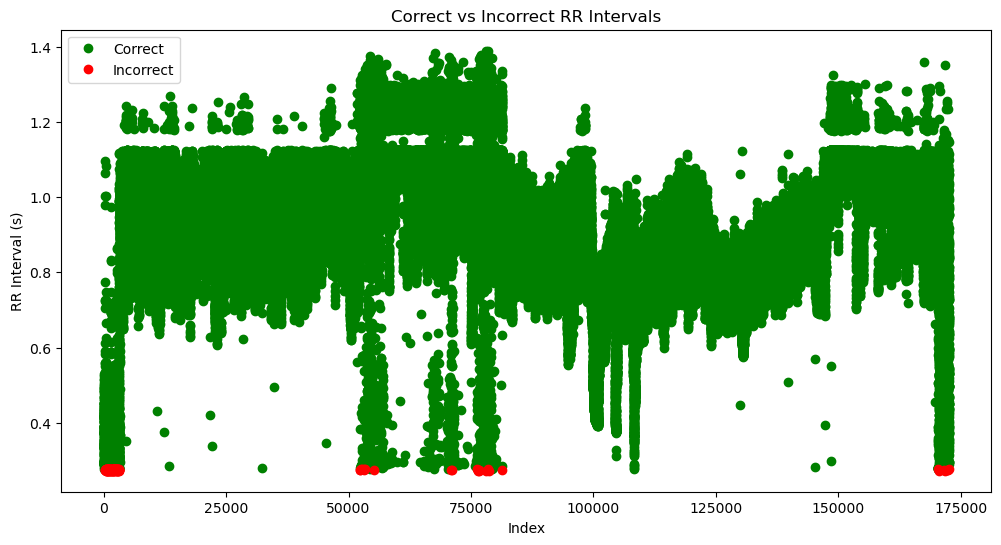

In [23]:
import matplotlib.pyplot as plt

# Define the threshold for comparison (30ms in seconds)
threshold_seconds = 0.03

# Initialize lists to store indices and values
incorrect_indices = []
correct_indices = []

# Iterate through the cleaned RR intervals
for idx, rr_val in enumerate(rr_clean):
    # Check if there is any detected RR interval within the threshold
    if np.any(np.abs(rr_intervals - rr_val) <= threshold_seconds):
        correct_indices.append(idx)
    else:
        incorrect_indices.append(idx)

# Save the indices
incorrect_indices = np.array(incorrect_indices)
correct_indices = np.array(correct_indices)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(correct_indices, rr_clean.iloc[correct_indices], 'go', label='Correct')
plt.plot(incorrect_indices, rr_clean.iloc[incorrect_indices], 'ro', label='Incorrect')
plt.xlabel('Index')
plt.ylabel('RR Interval (s)')
plt.title('Correct vs Incorrect RR Intervals')
plt.legend()
plt.show()

In [27]:
# Fra RR -> peak times (første peak ved t0=0 eller kendt starttid)
t_ref = np.r_[0.0, np.cumsum(rr_clean)]        # reference
t_test = np.r_[0.0, np.cumsum(rr_intervals)]   # test

def match_peaks(t_ref, t_test, tol=0.03):
    i = j = 0
    n_ref, n_test = len(t_ref), len(t_test)
    matches = []           # (i_ref, j_test, dt)
    ref_only = []          # i_ref uden match
    test_only = []         # j_test uden match

    while i < n_ref and j < n_test:
        dt = t_ref[i] - t_test[j]
        adt = abs(dt)

        if adt <= tol:
            # match én-til-én
            matches.append((i, j, dt))
            i += 1
            j += 1
        elif dt > tol:
            # test-peak kommer før ref-peak og ligger uden for tolerance → ekstra peak i test
            test_only.append(j)
            j += 1
        else:  # dt < -tol, ref-peak kommer før test-peak
            ref_only.append(i)
            i += 1

    # rester
    while i < n_ref:
        ref_only.append(i); i += 1
    while j < n_test:
        test_only.append(j); j += 1

    return matches, ref_only, test_only

matches, ref_only, test_only = match_peaks(t_ref, t_test, tol=0.03)

# Eksempel på logging/opsummering:
tp = len(matches)              # “enige” om R-peak
fn = len(ref_only)             # mangler i test (missed peaks)
fp = len(test_only)            # ekstra i test (spurious peaks)
mae = np.mean([abs(dt) for _,_,dt in matches]) if matches else np.nan

print(f"TP={tp}, FN={fn}, FP={fp}, MAE={mae*1000:.1f} ms")


TP=11097, FN=161553, FP=156237, MAE=15.1 ms


In [31]:
import pandas as pd
df_ref  = pd.DataFrame({'t': t_ref,  'i_ref':  np.arange(len(t_ref))})
df_test = pd.DataFrame({'t': t_test, 'j_test': np.arange(len(t_test))})

out = pd.merge_asof(df_ref.sort_values('t'),
                    df_test.sort_values('t'),
                    on='t', direction='nearest', tolerance=0.03)

# Matchede rækker har ikke-NA j_test
matched = out.dropna(subset=['j_test']).copy()
matched['dt'] = matched['t'] - t_test[matched['j_test'].astype(int).values]

# ref-only = rækker der ikke fandt nærmeste inden for tolerance
ref_only_idx = out.index[out['j_test'].isna()].to_numpy()

# test-only = dem i test, som aldrig blev valgt. Markér alt og fjern de matchede.
all_test = set(range(len(t_test)))
used_test = set(matched['j_test'].astype(int).tolist())
test_only_idx = np.array(sorted(all_test - used_test))

print(f"TP={len(matched)}, FN={len(ref_only_idx)}, FP={len(test_only_idx)}")
print(f"MAE={matched['dt'].abs().mean()*1000:.1f} ms")

TP=11097, FN=161553, FP=156237
MAE=15.1 ms


In [32]:
import numpy as np
import pandas as pd

# -------------------------------
# Hjælpere: lav peak-tider
# -------------------------------

def rr_to_peak_times(rr, t0=0.0):
    """Fra RR-intervaller (sek) -> peak-tider (sek), med første peak ved t0."""
    rr = np.asarray(rr, dtype=float).ravel()
    return t0 + np.r_[0.0, np.cumsum(rr)]

def idx_to_peak_times(idxs, fs, t0=0.0):
    """Fra peak-indeks (samples) -> peak-tider (sek)."""
    idxs = np.asarray(idxs, dtype=float).ravel()
    return t0 + idxs / float(fs)

# -------------------------------
# 1-til-1 matching med tolerance
# -------------------------------

def match_peaks_times(t_ref, t_pred, tol=0.03):
    """
    Matchér peaks 1-til-1 (greedy, lineært) efter tid.
    t_ref, t_pred i sek. tol i sek.
    Returnerer:
      matches: liste af (i_ref, j_pred, dt)
      ref_only: liste af i_ref uden match
      pred_only: liste af j_pred uden match
    """
    t_ref = np.asarray(t_ref, dtype=float).ravel()
    t_pred = np.asarray(t_pred, dtype=float).ravel()
    i = j = 0
    n_ref, n_pred = len(t_ref), len(t_pred)
    matches, ref_only, pred_only = [], [], []

    while i < n_ref and j < n_pred:
        dt = t_ref[i] - t_pred[j]
        adt = abs(dt)
        if adt <= tol:
            matches.append((i, j, dt))
            i += 1; j += 1
        elif dt > tol:
            # prediction-peak før reference -> ekstra i prediction
            pred_only.append(j); j += 1
        else:
            # reference-peak før prediction -> mangler i prediction
            ref_only.append(i); i += 1

    while i < n_ref:
        ref_only.append(i); i += 1
    while j < n_pred:
        pred_only.append(j); j += 1

    return matches, ref_only, pred_only

# -------------------------------
# Metrics + dataframes
# -------------------------------

def summarize_matching(t_ref, t_pred, tolerances=(0.0, 0.01, 0.02, 0.03, 0.05)):
    """
    Kør matching for flere tolerancer.
    Returnerer:
      metrics: dict[tol] -> dict med TP, FN, FP, MAE_ms, P95_ms
      tables: dict[tol] -> (matches_df, ref_only_df, pred_only_df)
    """
    metrics = {}
    tables = {}

    for tol in tolerances:
        matches, ref_only, pred_only = match_peaks_times(t_ref, t_pred, tol=tol)

        if matches:
            dts = np.array([dt for _,_,dt in matches], dtype=float)
            mae = float(np.mean(np.abs(dts))) * 1000.0
            p95 = float(np.percentile(np.abs(dts), 95)) * 1000.0
        else:
            mae = np.nan
            p95 = np.nan

        m = {
            "tolerance_ms": tol * 1000.0,
            "TP": len(matches),
            "FN": len(ref_only),
            "FP": len(pred_only),
            "MAE_ms": mae,
            "P95_ms": p95,
        }
        metrics[tol] = m

        # DataFrames til logging/inspektion
        matches_df = pd.DataFrame(
            [(i, j, t_ref[i], t_pred[j], d) for i, j, d in matches],
            columns=["i_ref", "j_pred", "t_ref_s", "t_pred_s", "dt_s"]
        )
        if len(matches_df):
            matches_df["abs_dt_ms"] = (matches_df["dt_s"].abs() * 1000.0)

        ref_only_df = pd.DataFrame(
            [(i, t_ref[i]) for i in ref_only],
            columns=["i_ref", "t_ref_s"]
        )
        pred_only_df = pd.DataFrame(
            [(j, t_pred[j]) for j in pred_only],
            columns=["j_pred", "t_pred_s"]
        )

        tables[tol] = (matches_df, ref_only_df, pred_only_df)

    return metrics, tables

# -------------------------------
# Convenience: kør fra RR eller indeks
# -------------------------------

def evaluate_from_rr(rr_ref, rr_pred, tolerances=(0.0, 0.03), t0_ref=0.0, t0_pred=0.0):
    t_ref = rr_to_peak_times(rr_ref, t0=t0_ref)
    t_pred = rr_to_peak_times(rr_pred, t0=t0_pred)
    return summarize_matching(t_ref, t_pred, tolerances=tolerances)

def evaluate_from_indices(ref_idx, pred_idx, fs, tolerances=(0.0, 0.03), t0_ref=0.0, t0_pred=0.0):
    t_ref = idx_to_peak_times(ref_idx, fs, t0=t0_ref)
    t_pred = idx_to_peak_times(pred_idx, fs, t0=t0_pred)
    return summarize_matching(t_ref, t_pred, tolerances=tolerances)


In [33]:
tols = (0.0, 0.03)  # 0 ms (præcis) og 30 ms vindue
metrics, tables = evaluate_from_rr(rr_clean, rr_intervals, tolerances=tols)

# Print metrics pænt
pd.DataFrame(metrics).T


,tolerance_ms,TP,FN,FP,MAE_ms,P95_ms
0.00,0.0,1.0,172649.0,167333.0,0.000000,0.0000
0.03,30.0,11097.0,161553.0,156237.0,15.115108,28.5822


In [35]:
tol = 0.03
matches_df, ref_only_df, pred_only_df = tables[tol]
print(metrics[tol])  # {'tolerance_ms': 30.0, 'TP': ..., 'FN': ..., 'FP': ..., 'MAE_ms': ..., 'P95_ms': ...}

# Gem hvis du vil
# matches_df.to_csv("matches_30ms.csv", index=False)
# ref_only_df.to_csv("missed_ref_30ms.csv", index=False)
# pred_only_df.to_csv("extra_pred_30ms.csv", index=False)


{'tolerance_ms': 30.0, 'TP': 11097, 'FN': 161553, 'FP': 156237, 'MAE_ms': 15.115108087219628, 'P95_ms': 28.582200390519567}


Precise matches: 359
Matches within a window of 30ms: 172649
Total RR intervals in rr_clean: 172649
Total RR intervals in rr_intervals: 167333
Number of correct matches: 172649
Number of incorrect matches: 0
Accuracy: 100.00%


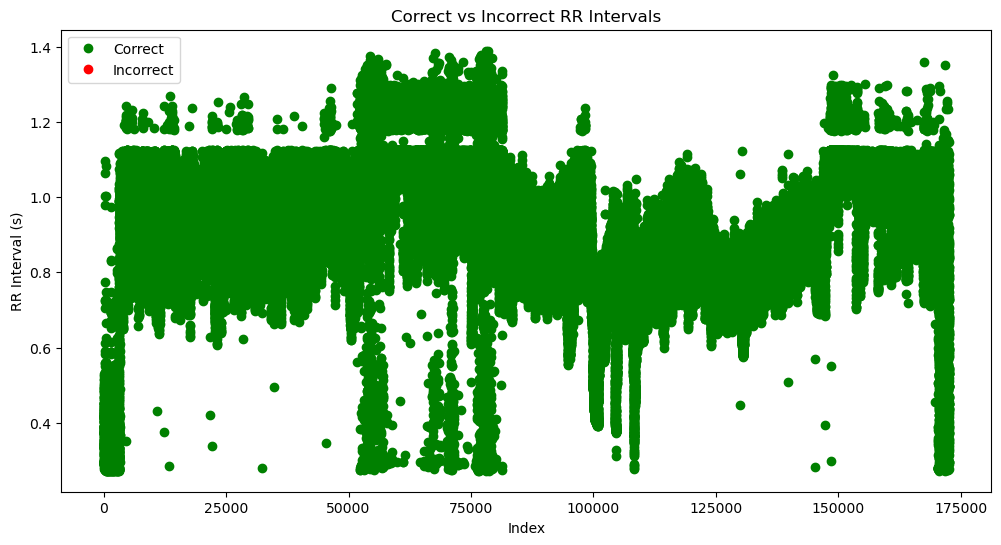

In [53]:
# Define the threshold for comparison (40ms in seconds)
threshold_seconds = 0.04

# Initialize counters for precise matches and matches within the threshold
precise_matches = 0
window_matches = 0

# Iterate through the cleaned RR intervals
for rr_val in rr_clean:
    # Check for precise match
    if rr_val in rr_intervals:
        precise_matches += 1

    # Check for match within the threshold
    if np.any(np.abs(rr_intervals - rr_val) <= threshold_seconds):
        window_matches += 1

# Print the results
print(f"Precise matches: {precise_matches}")
print(f"Matches within a window of 30ms: {window_matches}")
print(f"Total RR intervals in rr_clean: {len(rr_clean)}")
print(f"Total RR intervals in rr_intervals: {len(rr_intervals)}")


# Initialize counters for correct and incorrect indices
correct_indices = []
incorrect_indices = []

# Iterate through the cleaned RR intervals
for idx, rr_val in enumerate(rr_clean):
    # Check if there is any detected RR interval within the threshold
    if np.any(np.abs(rr_intervals - rr_val) <= threshold_seconds):
        correct_indices.append(idx)
    else:
        incorrect_indices.append(idx)

# Save the indices
correct_indices = np.array(correct_indices)
incorrect_indices = np.array(incorrect_indices)

# Calculate the number of correct and incorrect matches
num_correct = len(correct_indices)
num_incorrect = len(incorrect_indices)

# Print the results
print(f"Number of correct matches: {num_correct}")
print(f"Number of incorrect matches: {num_incorrect}")
print(f"Accuracy: {num_correct / len(rr_clean) * 100:.2f}%")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(correct_indices, rr_clean.iloc[correct_indices], 'go', label='Correct')
plt.plot(incorrect_indices, rr_clean.iloc[incorrect_indices], 'ro', label='Incorrect')
plt.xlabel('Index')
plt.ylabel('RR Interval (s)')
plt.title('Correct vs Incorrect RR Intervals')
plt.legend()
plt.show()

In [46]:
0.03/ (1/512)

15.36

In [15]:
import numpy as np
import pandas as pd

def load_labview_rr(path):
    """Læs RR-intervaller (sek) fra LVM/tekst med dansk decimalkomma eller punktum."""
    # Først prøv tab + decimalkomma (klassisk LVM)
    try:
        df = pd.read_csv(path, sep="\t", engine="python", skiprows=22, header=0, decimal=",")
    except Exception:
        # Fallback: autodetect sep, men tving decimal-komma -> punktum
        df = pd.read_csv(path, sep=None, engine="python", skiprows=22, header=0)
        df = df.apply(lambda s: pd.to_numeric(s.astype(str).str.replace(",", "."), errors="coerce"))
    # Vælg RR-kolonne (typisk "Untitled"); ellers vælg bedste numeriske kandidat ≈ sekunder
    cols = [c for c in df.columns if str(c).lower() not in ("x_value", "xvalue", "comment")]
    if "Untitled" in df.columns:
        rr = pd.to_numeric(df["Untitled"], errors="coerce").dropna().to_numpy(dtype=float)
    elif cols:
        # vælg første kolonne der ligner sekunder (median 0.2–3 s)
        rr = None
        for c in cols:
            v = pd.to_numeric(df[c], errors="coerce").dropna().to_numpy(dtype=float)
            med = np.median(v) if v.size else np.nan
            if 0.1 < med < 5.0:
                rr = v; break
        if rr is None:
            rr = pd.to_numeric(df[cols[0]], errors="coerce").dropna().to_numpy(dtype=float)
    else:
        raise ValueError("Fandt ingen RR-kolonne i filen.")
    # Enhedscheck (skulle gerne være sekunder allerede)
    med = np.median(rr)
    if med > 10000: rr = rr / 1_000_000.0  # µs -> s
    elif med > 5:   rr = rr / 1_000.0      # ms -> s
    return rr

def rr_to_dataframe(rr_seconds, fs=512.0, t0=0.0):
    """
    Byg et DataFrame for R-peaks ud fra RR-intervaller i sekunder.
    - rr_seconds[i] = tid mellem peak i og i-1
    - første peak sættes til tid t0 (typisk 0.0)
    """
    rr = np.asarray(rr_seconds, dtype=float)

    # Tidsstempler for peaks: første peak ved t0, derefter kumulerede RR
    # peak 0: t0
    # peak 1: t0 + rr[0]
    # peak 2: t0 + rr[0] + rr[1], ...
    t_peaks = t0 + np.cumsum(np.insert(rr, 0, 0.0))

    # Sampleindeks for peaks (afrundet til nærmeste heltal)
    i_peaks = np.rint(t_peaks * fs).astype(np.int64)

    # HR (bpm) pr. interval: 60 / RR (første er NaN)
    hr = np.empty_like(t_peaks)
    hr[:] = np.nan
    hr[1:] = 60.0 / rr

    # Saml DataFrame
    df = pd.DataFrame({
        "peak_idx": np.arange(len(t_peaks), dtype=int),
        "t_s": t_peaks,
        "sample": i_peaks,
        "rr_s": np.insert(rr, 0, np.nan),
        "hr_bpm": hr
    })

    return df

def make_binary_series(peak_samples, n_samples=None):
    """
    (Valgfrit) Lav en binær serie med 1 ved peak-samples.
    Hvis n_samples ikke gives, bruger vi sidste peak + 1 sekund buffer.
    """
    if n_samples is None:
        n_samples = int(peak_samples[-1] + 0.5*512)  # lille buffer
    x = np.zeros(n_samples, dtype=np.uint8)
    valid = peak_samples[(peak_samples >= 0) & (peak_samples < n_samples)]
    x[valid] = 1
    return x

# ---- Brug det sådan her ----
rr_path = r"E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results\Patient5_1-corrected-rr.lvm"
fs = 512.0
wf_increment = 1.0 / fs  # hvis du vil gemme det

lab_rr = load_labview_rr(rr_path)              # RR i sekunder
df_lab = rr_to_dataframe(lab_rr, fs=fs, t0=0)  # t0=0 da LabVIEW har trimmet før første peak

print(df_lab.head())
print(df_lab.tail())
print("Antal peaks:", len(df_lab))

# (Valgfrit) binær peak-serie til event-baseret sammenligning:
binary_peaks = make_binary_series(df_lab["sample"].to_numpy(), n_samples=None)


   peak_idx       t_s  sample      rr_s      hr_bpm
0         0  0.000000       0       NaN         NaN
1         1  0.331858     170  0.331858  180.800222
2         2  0.714762     366  0.382904  156.697240
3         3  0.882633     452  0.167871  357.417303
4         4  1.086972     557  0.204339  293.629704
        peak_idx            t_s    sample      rr_s      hr_bpm
186080    186080  160683.771834  82270091  0.195312  307.200786
186081    186081  160684.012775  82270215  0.240941  249.023620
186082    186082  160684.483715  82270456  0.470940  127.404765
186083    186083  160684.737621  82270586  0.253906  236.307925
186084    186084  160685.028189  82270734  0.290568  206.492112
Antal peaks: 186085


In [16]:
print("Binær peak-serie længde:", len(binary_peaks))

indices_with_ones = np.flatnonzero(binary_peaks)[:10]
print(f"First 10 indices with 1's in binary_peaks: {indices_with_ones}")

Binær peak-serie længde: 82270990
First 10 indices with 1's in binary_peaks: [   0  170  366  452  557  669  828  894  976 1085]


In [26]:

print("Sample amount with start_samples:", sample_difference + len(binary_peaks))

print("Missing time in seconds:", (82460288 - (sample_difference + len(binary_peaks))) / fs)

Sample amount with start_samples: 82310507.006848
Missing time in seconds: 292.54100224998547


In [18]:
# Compared with total length of ECG signal: 82460288 samples
